# Lucas Kanade implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import cv2 as cv
import math
import matplotlib.cm as cm
from scipy.signal import convolve2d
import random

In [2]:
def Lucas_Kanade(image1, image2, window=3):
    oldframe = cv.imread(image1)
    I1 = cv.cvtColor(oldframe, cv.COLOR_BGR2GRAY)
    I1 = I1/255.0 # normalizing
    plt.show()
    
    w = window//2

    newframe = cv.imread(image2)
    I2 = cv.cvtColor(newframe, cv.COLOR_BGR2GRAY)
    I2 = I2/255.0 # normalizing
    

    color = np.random.randint(0, 255, (100, 3))
    Gx = np.reshape(np.asarray([[-1, 1], [-1, 1]]), (2, 2))  # for image 1 and image 2 in x direction
    Gy = np.reshape(np.asarray([[-1, -1], [1, 1]]), (2, 2))  # for image 1 and image 2 in y direction
    Gt1 = np.reshape(np.asarray([[-1, -1], [-1, -1]]), (2, 2))  # for 1st image
    Gt2 = np.reshape(np.asarray([[1, 1], [1, 1]]), (2, 2))  # for 2nd image


    Ix = (convolve2d(I1, Gx) + convolve2d(I2, Gx)) / 2 #smoothing in x direction

    Iy = (convolve2d(I1, Gy) + convolve2d(I2, Gy)) / 2 #smoothing in y direction
    It1 = convolve2d(I1, Gt1) + convolve2d(I2, Gt2)   #taking difference of two images using gaussian mask of all -1 and all 1

    # parameter to get features
    feature_params = dict(maxCorners=100,
                          qualityLevel=0.3,
                          minDistance=7,
                          blockSize=7)
    

    I1 = np.float32(I1)
    I2 = np.float32(I2)
    features = cv.goodFeaturesToTrack(I1, mask = None, **feature_params)  #using opencv function to get feature for which we are plotting flow
    
    feature = np.int32(features)
    
    feature = np.reshape(feature, newshape=[-1, 2])

    u = np.ones(Ix.shape)
    v = np.ones(Ix.shape)
    status=np.zeros(feature.shape[0]) # this will tell change in x,y
    A = np.zeros((2, 2))
    B = np.zeros((2, 1))
    mask = np.zeros_like(oldframe)

    newFeature=np.zeros_like(feature)
    """Assumption is  that all the neighbouring pixels will have similar motion. 
    Lucas-Kanade method takes a 3x3 patch around the point. So all the 9 points have the same motion.
    We can find (fx,fy,ft) for these 9 points. So now our problem becomes solving 9 equations with two unknown variables which is over-determined. 
    A better solution is obtained with least square fit method.
    Below is the final solution which is two equation-two unknown problem and solve to get the solution.
                               U=Ainverse*B 
    where U is matrix of 1 by 2 and contains change in x and y direction(x==U[0] and y==U[1])
    we first calculate A matrix which is 2 by 2 matrix of [[fx**2, fx*fy],[ fx*fy fy**2] and now take inverse of it
    and B is -[[fx*ft1],[fy,ft2]]"""

    for a,i in enumerate(feature):

        x, y = i


        A[0, 0] = np.sum((Ix[y - w:y + w+1, x - w:x + w + 1]) ** 2)

        A[1, 1] = np.sum((Iy[y - w:y + w+1, x - w:x + w + 1]) ** 2)
        A[0, 1] = np.sum(Ix[y - w:y + w+1, x - w:x + w + 1] * Iy[y - w:y + w+1, x - w:x + w + 1])
        A[1, 0] = np.sum(Ix[y - w:y + w+1, x - w:x + w + 1] * Iy[y - w:y + w + 1, x - w:x + w + 1])
        Ainv = np.linalg.pinv(A)

        B[0, 0] = -np.sum(Ix[y - w:y + w + 1, x - w:x + w + 1] * It1[y - w:y + w + 1, x - w:x + w + 1])
        B[1, 0] = -np.sum(Iy[y - w:y + w + 1, x - w:x + w + 1] * It1[y - w:y + w + 1, x - w:x + w + 1])
        prod = np.matmul(Ainv, B)

        u[y, x] = prod[0]
        v[y, x] = prod[1]

        newFeature[a]=[np.int32(x+u[y,x]),np.int32(y+v[y,x])]
        if np.int32(x+u[y,x])==x and np.int32(y+v[y,x])==y:    # this means that there is no change(x+dx==x,y+dy==y) so marking it as 0 else
            status[a]=0
        else:
            status[a]=1 # this tells us that x+dx , y+dy is not equal to x and y

    um=np.flipud(u)
    vm=np.flipud(v)

    good_new=newFeature[status==1] #status will tell the position where x and y are changed so for plotting getting only that points
    good_old = feature[status==1]
    print(good_new.shape)
    print(good_old.shape)

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        newframe = cv.circle(newframe, (a, b), 5, color[i].tolist(), -1)
    img = cv.add(newframe, mask)
    return img

# with window size = 3

(15, 2)
(15, 2)


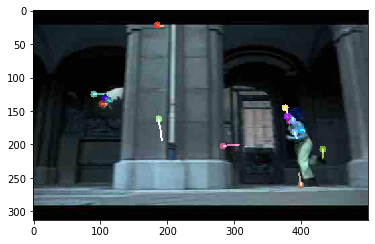

True

In [3]:
image=Lucas_Kanade("rseq01.png", "rseq02.png")
plt.imshow(image)
plt.show()
cv.imwrite("w3.png", image)

# With window size = 9

(14, 2)
(14, 2)


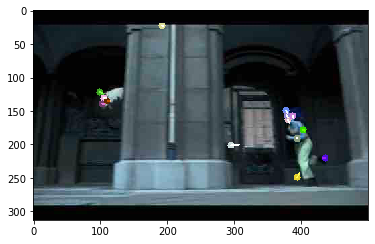

True

In [4]:
image=Lucas_Kanade("rseq01.png", "rseq02.png", 9)
plt.imshow(image)
plt.show()
cv.imwrite("w9.png", image)

# with window size = 15

(15, 2)
(15, 2)


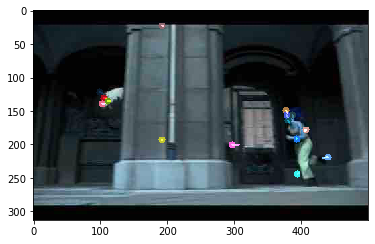

True

In [5]:
image=Lucas_Kanade("rseq01.png", "rseq02.png", 15)
plt.imshow(image)
plt.show()
cv.imwrite("w15.png", image)